In [4]:
# ============================================================================
# COMPLETE IMPROVED PM2.5 PREDICTION MODEL USING RANDOM FOREST REGRESSOR
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint
import joblib

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12





In [5]:
# ============================================================================
# STEP 1: LOAD AND INITIAL EXPLORATION
# ============================================================================

print("="*70)
print("PM2.5 PREDICTION USING RANDOM FOREST - KHUMALTAR")
print("="*70)

# Load your data
file_path = r'C:\Users\LOQ\Downloads\Bikke Sir\datasets\Khumaltar hourly merged 2022-2024.csv'
df = pd.read_csv(file_path, encoding='latin1')

print("\n" + "="*70)
print("STEP 1: INITIAL DATA EXPLORATION")
print("="*70)

print(f"\n✅ Dataset loaded successfully!")
print(f"📊 Dataset Shape: {df.shape}")
print(f"📋 Number of rows: {df.shape[0]:,}")
print(f"📋 Number of columns: {df.shape[1]}")

print("\n📋 Column Names:")
for i, col in enumerate(df.columns):
    print(f"   {i+1}. '{col}'")

print("\n📊 First 5 rows:")
print(df.head())

print("\n📊 Data Types:")
print(df.dtypes)


PM2.5 PREDICTION USING RANDOM FOREST - KHUMALTAR

STEP 1: INITIAL DATA EXPLORATION

✅ Dataset loaded successfully!
📊 Dataset Shape: (26303, 5)
📋 Number of rows: 26,303
📋 Number of columns: 5

📋 Column Names:
   1. 'date'
   2. 'Khumaltar Temperature (°C)'
   3. 'Khumaltar Relative Humidity (%)'
   4. 'PM2.5'
   5. 'PM10'

📊 First 5 rows:
            date  Khumaltar Temperature (°C)  Khumaltar Relative Humidity (%)  \
0  1/1/2022 0:00                         3.2                            100.0   
1  1/1/2022 1:00                         2.9                            100.0   
2  1/1/2022 2:00                         3.8                            100.0   
3  1/1/2022 3:00                         5.1                            100.0   
4  1/1/2022 4:00                         7.0                            100.0   

   PM2.5  PM10  
0    NaN   NaN  
1    NaN   NaN  
2    NaN   NaN  
3    NaN   NaN  
4    NaN   NaN  

📊 Data Types:
date                                   str
Khumaltar Tem

In [6]:
# ============================================================================
# STEP 2: COLUMN RENAMING (MODIFY THIS BASED ON YOUR ACTUAL COLUMN NAMES)
# ============================================================================

print("\n" + "="*70)
print("STEP 2: COLUMN STANDARDIZATION")
print("="*70)

# !!! IMPORTANT: Modify these mappings based on your actual column names !!!
column_mapping = {
    'date': 'datetime',      # Replace with your date column name
    'Khumaltar Temperature (°C)': 'temperature',    # Replace with your temperature column name
    'Khumaltar Relative Humidity (%)': 'relative_humidity',  # Replace with your humidity column name
    'PM2.5': 'pm25'            # Replace with your PM2.5 column name
}

# Check which columns exist and rename
existing_mappings = {old: new for old, new in column_mapping.items() if old in df.columns}
df = df.rename(columns=existing_mappings)

print(f"\n✅ Columns renamed: {list(existing_mappings.keys())}")
print(f"\n📋 Updated column names:")
print(df.columns.tolist())




STEP 2: COLUMN STANDARDIZATION

✅ Columns renamed: ['date', 'Khumaltar Temperature (°C)', 'Khumaltar Relative Humidity (%)', 'PM2.5']

📋 Updated column names:
['datetime', 'temperature', 'relative_humidity', 'pm25', 'PM10']


In [7]:
# ============================================================================
# STEP 3: DATETIME PROCESSING
# ============================================================================

print("\n" + "="*70)
print("STEP 3: DATETIME PROCESSING")
print("="*70)

# Check datetime column
if 'datetime' in df.columns:
    print(f"\n📊 Datetime column sample:")
    print(df['datetime'].head(10).tolist())
    
    # Convert to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    
    # Check conversion
    invalid_dates = df['datetime'].isna().sum()
    print(f"\n✅ Datetime conversion complete")
    print(f"❌ Invalid dates found: {invalid_dates} ({invalid_dates/len(df)*100:.2f}%)")
    
    # Remove invalid dates
    if invalid_dates > 0:
        df = df.dropna(subset=['datetime'])
        print(f"✅ Removed {invalid_dates} rows with invalid dates")
else:
    print("\n⚠️ No datetime column found. Please check column names.")
    # Create a dummy datetime index if needed
    df['datetime'] = pd.date_range(start='2022-01-01', periods=len(df), freq='H')

# Sort by datetime
df = df.sort_values('datetime').reset_index(drop=True)
print(f"✅ Data sorted chronologically")



STEP 3: DATETIME PROCESSING

📊 Datetime column sample:
['1/1/2022 0:00', '1/1/2022 1:00', '1/1/2022 2:00', '1/1/2022 3:00', '1/1/2022 4:00', '1/1/2022 5:00', '1/1/2022 6:00', '1/1/2022 7:00', '1/1/2022 8:00', '1/1/2022 9:00']

✅ Datetime conversion complete
❌ Invalid dates found: 0 (0.00%)
✅ Data sorted chronologically



STEP 4: COMPREHENSIVE EXPLORATORY DATA ANALYSIS

--- 4.1 Descriptive Statistics ---
        temperature  relative_humidity          pm25
count  24887.000000       24879.000000  23097.000000
mean      18.261092          77.726267     43.152566
std        6.691601          22.976761     31.619691
min        1.100000           5.900000      0.606897
25%       13.400000          60.700000     16.510527
50%       19.800000          84.500000     36.696611
75%       23.100000         100.000000     61.968334
max       32.900000         100.000000    210.689833

--- 4.2 Missing Values Analysis ---
                   Missing Count  Missing Percent
temperature                 1416         5.383416
relative_humidity           1424         5.413831
pm25                        3206        12.188724
PM10                        2945        11.196441


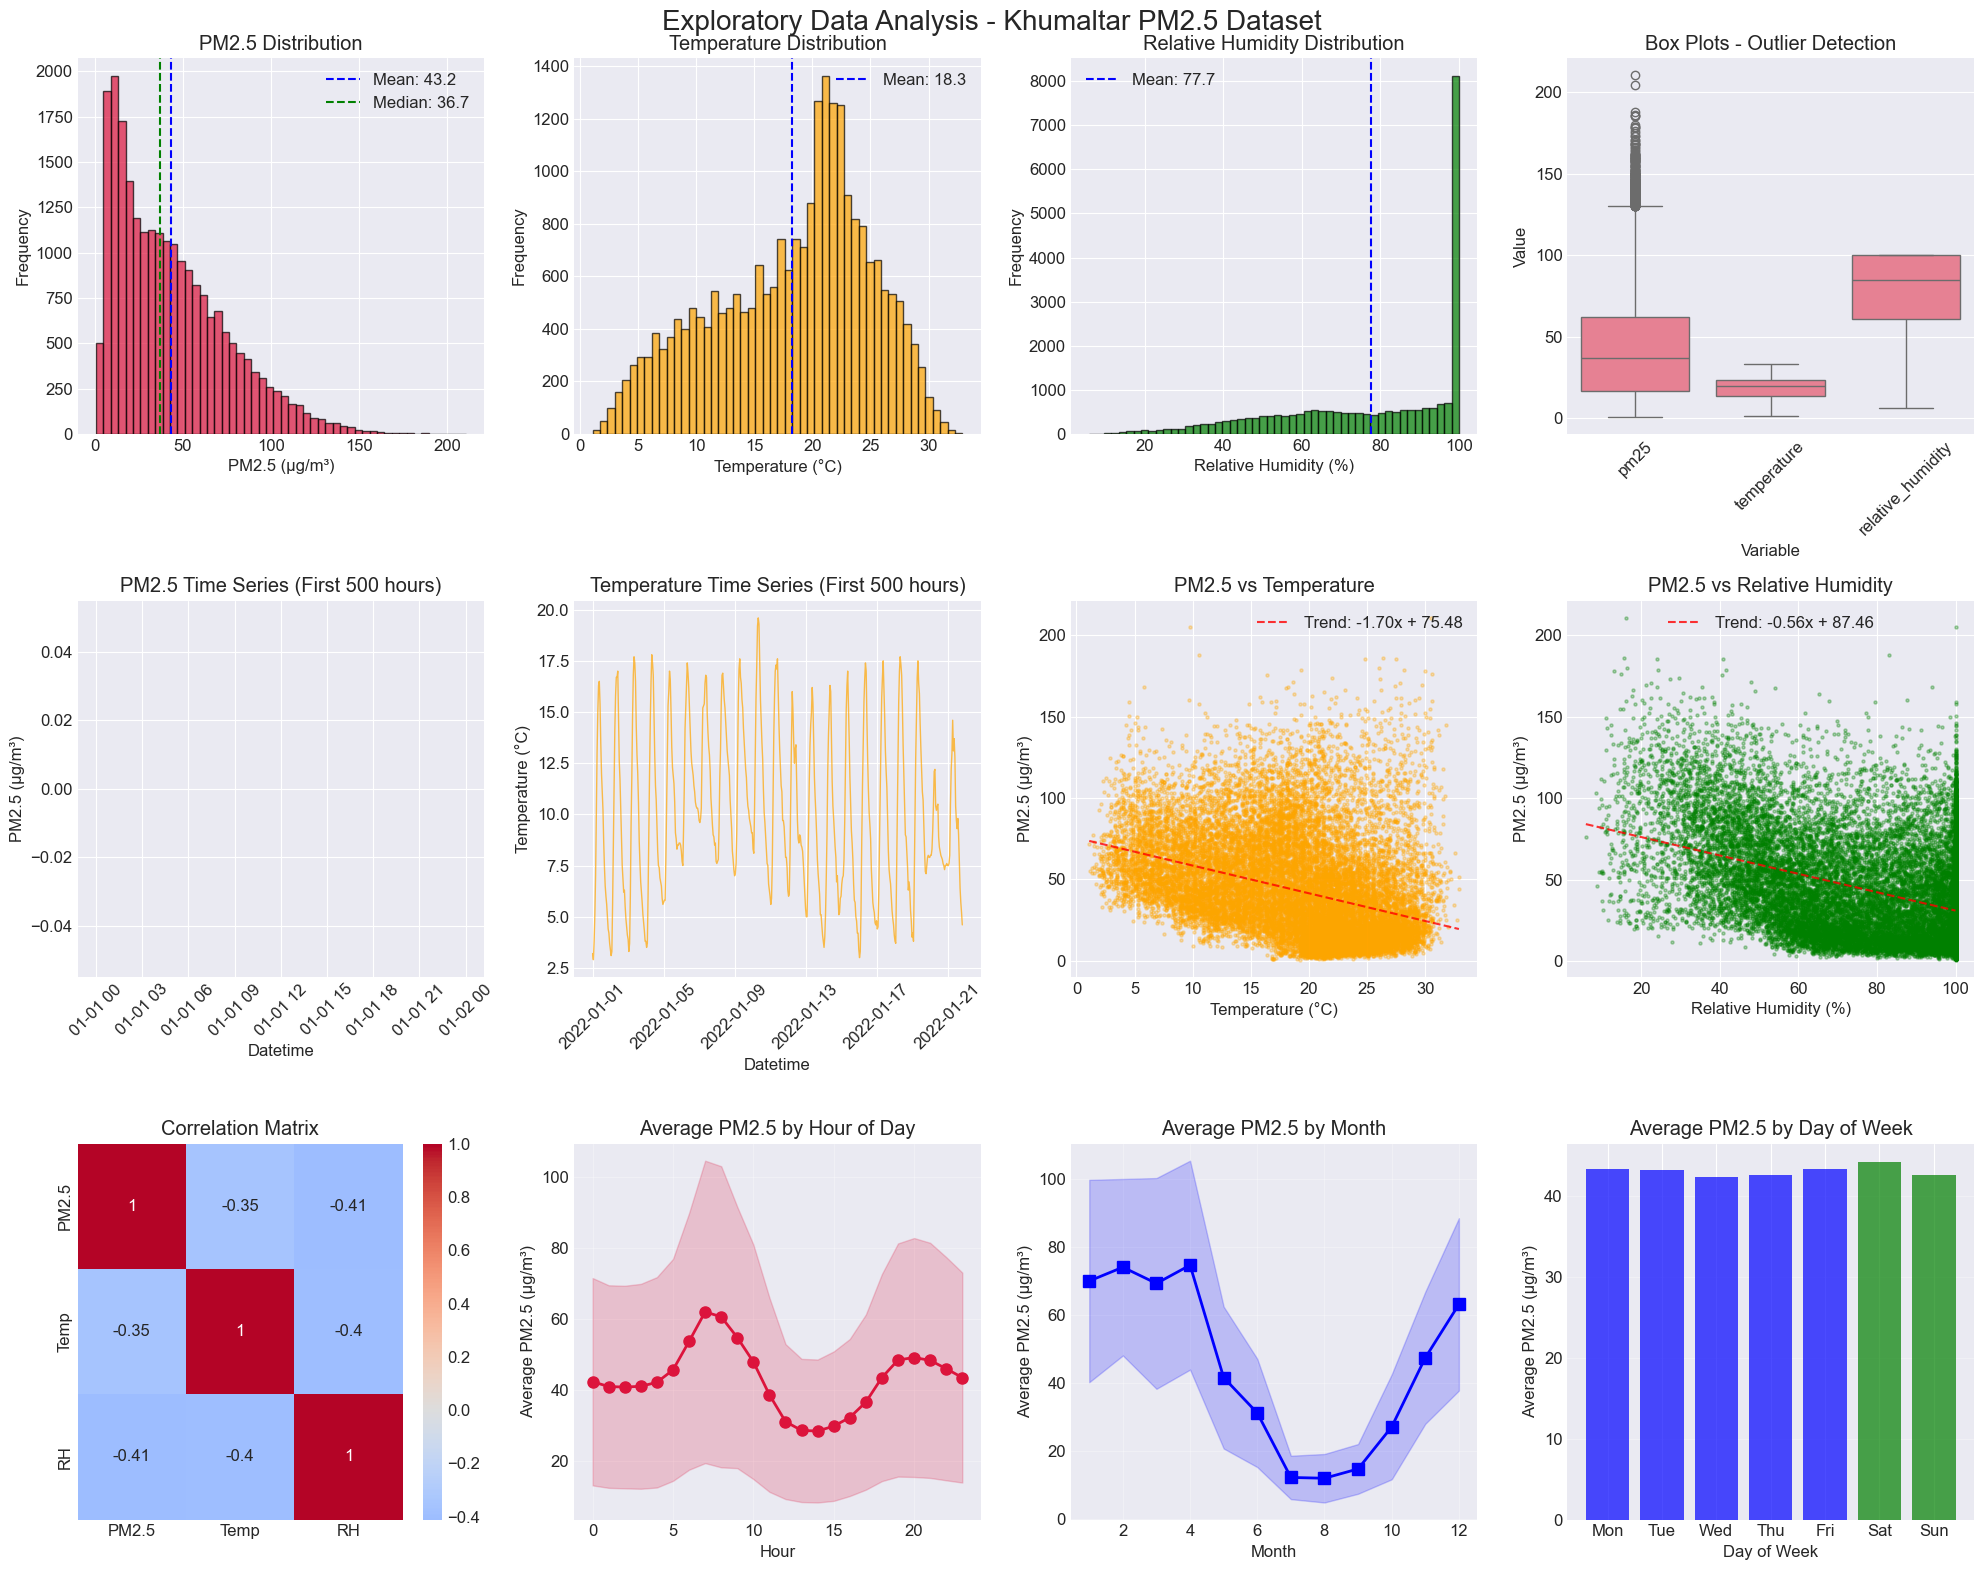

In [8]:
# ============================================================================
# STEP 4: COMPREHENSIVE EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "="*70)
print("STEP 4: COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
print("="*70)

# 4.1 Basic Statistics
print("\n--- 4.1 Descriptive Statistics ---")
print(df[['temperature', 'relative_humidity', 'pm25']].describe())

# 4.2 Missing Values Analysis
print("\n--- 4.2 Missing Values Analysis ---")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percent': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

# 4.3 Create EDA Visualizations
fig = plt.figure(figsize=(20, 16))
fig.suptitle('Exploratory Data Analysis - Khumaltar PM2.5 Dataset', fontsize=20, y=0.98)

# 4.3.1 Distribution Plots
ax1 = plt.subplot(3, 4, 1)
df['pm25'].hist(bins=50, edgecolor='black', alpha=0.7, color='crimson')
ax1.set_title('PM2.5 Distribution')
ax1.set_xlabel('PM2.5 (µg/m³)')
ax1.set_ylabel('Frequency')
ax1.axvline(df['pm25'].mean(), color='blue', linestyle='--', label=f'Mean: {df["pm25"].mean():.1f}')
ax1.axvline(df['pm25'].median(), color='green', linestyle='--', label=f'Median: {df["pm25"].median():.1f}')
ax1.legend()

ax2 = plt.subplot(3, 4, 2)
df['temperature'].hist(bins=50, edgecolor='black', alpha=0.7, color='orange')
ax2.set_title('Temperature Distribution')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Frequency')
ax2.axvline(df['temperature'].mean(), color='blue', linestyle='--', label=f'Mean: {df["temperature"].mean():.1f}')
ax2.legend()

ax3 = plt.subplot(3, 4, 3)
df['relative_humidity'].hist(bins=50, edgecolor='black', alpha=0.7, color='green')
ax3.set_title('Relative Humidity Distribution')
ax3.set_xlabel('Relative Humidity (%)')
ax3.set_ylabel('Frequency')
ax3.axvline(df['relative_humidity'].mean(), color='blue', linestyle='--', label=f'Mean: {df["relative_humidity"].mean():.1f}')
ax3.legend()

# 4.3.2 Box Plots
ax4 = plt.subplot(3, 4, 4)
df_box = df[['pm25', 'temperature', 'relative_humidity']].melt(var_name='Variable', value_name='Value')
sns.boxplot(data=df_box, x='Variable', y='Value', ax=ax4)
ax4.set_title('Box Plots - Outlier Detection')
ax4.tick_params(axis='x', rotation=45)

# 4.3.3 Time Series
ax5 = plt.subplot(3, 4, 5)
df_sample = df.iloc[:500]  # First 500 hours
ax5.plot(df_sample['datetime'], df_sample['pm25'], linewidth=1, color='crimson', alpha=0.7)
ax5.set_title('PM2.5 Time Series (First 500 hours)')
ax5.set_xlabel('Datetime')
ax5.set_ylabel('PM2.5 (µg/m³)')
ax5.tick_params(axis='x', rotation=45)

ax6 = plt.subplot(3, 4, 6)
ax6.plot(df_sample['datetime'], df_sample['temperature'], linewidth=1, color='orange', alpha=0.7)
ax6.set_title('Temperature Time Series (First 500 hours)')
ax6.set_xlabel('Datetime')
ax6.set_ylabel('Temperature (°C)')
ax6.tick_params(axis='x', rotation=45)

# 4.3.4 Scatter Plots - QUICK FIX
ax7 = plt.subplot(3, 4, 7)

# Get rows where both temperature and PM2.5 are valid
valid_data = df[['temperature', 'pm25']].dropna()
ax7.scatter(valid_data['temperature'], valid_data['pm25'], alpha=0.3, s=5, c='orange')
ax7.set_title('PM2.5 vs Temperature')
ax7.set_xlabel('Temperature (°C)')
ax7.set_ylabel('PM2.5 (µg/m³)')

# Add trend line
if len(valid_data) > 1:
    z = np.polyfit(valid_data['temperature'], valid_data['pm25'], 1)
    p = np.poly1d(z)
    x_sorted = np.sort(valid_data['temperature'])
    ax7.plot(x_sorted, p(x_sorted), "r--", alpha=0.8, 
             label=f'Trend: {z[0]:.2f}x + {z[1]:.2f}')
    ax7.legend()

ax8 = plt.subplot(3, 4, 8)

# Get rows where both humidity and PM2.5 are valid
valid_data = df[['relative_humidity', 'pm25']].dropna()
ax8.scatter(valid_data['relative_humidity'], valid_data['pm25'], alpha=0.3, s=5, c='green')
ax8.set_title('PM2.5 vs Relative Humidity')
ax8.set_xlabel('Relative Humidity (%)')
ax8.set_ylabel('PM2.5 (µg/m³)')

# Add trend line
if len(valid_data) > 1:
    z = np.polyfit(valid_data['relative_humidity'], valid_data['pm25'], 1)
    p = np.poly1d(z)
    x_sorted = np.sort(valid_data['relative_humidity'])
    ax8.plot(x_sorted, p(x_sorted), "r--", alpha=0.8, 
             label=f'Trend: {z[0]:.2f}x + {z[1]:.2f}')
    ax8.legend()
    
# 4.3.5 Correlation Heatmap
ax9 = plt.subplot(3, 4, 9)
corr_matrix = df[['pm25', 'temperature', 'relative_humidity']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax9, 
            xticklabels=['PM2.5', 'Temp', 'RH'], yticklabels=['PM2.5', 'Temp', 'RH'])
ax9.set_title('Correlation Matrix')

# 4.3.6 Hourly Pattern
ax10 = plt.subplot(3, 4, 10)
df['hour'] = df['datetime'].dt.hour
hourly_stats = df.groupby('hour')['pm25'].agg(['mean', 'std']).reset_index()
ax10.plot(hourly_stats['hour'], hourly_stats['mean'], 'o-', linewidth=2, markersize=8, color='crimson')
ax10.fill_between(hourly_stats['hour'], 
                   hourly_stats['mean'] - hourly_stats['std'],
                   hourly_stats['mean'] + hourly_stats['std'],
                   alpha=0.2, color='crimson')
ax10.set_title('Average PM2.5 by Hour of Day')
ax10.set_xlabel('Hour')
ax10.set_ylabel('Average PM2.5 (µg/m³)')
ax10.grid(True, alpha=0.3)

# 4.3.7 Monthly Pattern
ax11 = plt.subplot(3, 4, 11)
df['month'] = df['datetime'].dt.month
monthly_stats = df.groupby('month')['pm25'].agg(['mean', 'std']).reset_index()
ax11.plot(monthly_stats['month'], monthly_stats['mean'], 's-', linewidth=2, markersize=8, color='blue')
ax11.fill_between(monthly_stats['month'], 
                   monthly_stats['mean'] - monthly_stats['std'],
                   monthly_stats['mean'] + monthly_stats['std'],
                   alpha=0.2, color='blue')
ax11.set_title('Average PM2.5 by Month')
ax11.set_xlabel('Month')
ax11.set_ylabel('Average PM2.5 (µg/m³)')
ax11.grid(True, alpha=0.3)

# 4.3.8 Day of Week Pattern
ax12 = plt.subplot(3, 4, 12)
df['dayofweek'] = df['datetime'].dt.dayofweek
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_stats = df.groupby('dayofweek')['pm25'].mean()
ax12.bar(day_names, dow_stats.values, color=['blue']*5 + ['green']*2, alpha=0.7)
ax12.set_title('Average PM2.5 by Day of Week')
ax12.set_xlabel('Day of Week')
ax12.set_ylabel('Average PM2.5 (µg/m³)')
ax12.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()



In [44]:
# ============================================================================
# STEP 5: ADVANCED FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*70)
print("STEP 5: ADVANCED FEATURE ENGINEERING")
print("="*70)

def create_advanced_features(df):
    """Create comprehensive features for PM2.5 prediction"""
    
    df = df.copy()
    original_cols = len(df.columns)
    
    # Basic time features
    df['hour'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['dayofyear'] = df['datetime'].dt.dayofyear
    df['weekofyear'] = df['datetime'].dt.isocalendar().week
    
    # Cyclical encoding (better than raw hour/month)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # Weekend indicator
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Time of day categories
    df['time_of_day'] = pd.cut(df['hour'], 
                                 bins=[0, 6, 12, 18, 24], 
                                 labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                 include_lowest=True)
    
    # Lag features (previous values)
    print("\n⏳ Creating lag features...")
    for lag in [1, 2, 3, 6, 12, 24, 48, 72]:  # Multiple lag periods
        df[f'pm25_lag_{lag}'] = df['pm25'].shift(lag)
        df[f'temp_lag_{lag}'] = df['temperature'].shift(lag)
        df[f'humidity_lag_{lag}'] = df['relative_humidity'].shift(lag)
    
    # Rolling statistics
    print("⏳ Creating rolling statistics...")
    for window in [3, 6, 12, 24, 48, 72]:
        df[f'pm25_rolling_mean_{window}'] = df['pm25'].rolling(window=window, min_periods=1).mean()
        df[f'pm25_rolling_std_{window}'] = df['pm25'].rolling(window=window, min_periods=1).std()
        df[f'pm25_rolling_max_{window}'] = df['pm25'].rolling(window=window, min_periods=1).max()
        df[f'pm25_rolling_min_{window}'] = df['pm25'].rolling(window=window, min_periods=1).min()
        df[f'temp_rolling_mean_{window}'] = df['temperature'].rolling(window=window, min_periods=1).mean()
        df[f'humidity_rolling_mean_{window}'] = df['relative_humidity'].rolling(window=window, min_periods=1).mean()
    
    # Rate of change
    print("⏳ Creating rate of change features...")
    df['pm25_change_1hr'] = df['pm25'].diff(1)
    df['pm25_change_3hr'] = df['pm25'].diff(3)
    df['pm25_change_6hr'] = df['pm25'].diff(6)
    df['temp_change_1hr'] = df['temperature'].diff(1)
    df['humidity_change_1hr'] = df['relative_humidity'].diff(1)

    df['trend_3_6'] = df['pm25_rolling_mean_3'] - df['pm25_rolling_mean_6']
    df['acceleration'] = df['pm25_change_1hr'] - df['pm25_change_3hr']
    
    # Acceleration (rate of change of rate of change)
    df['pm25_acceleration'] = df['pm25_change_1hr'].diff(1)
    
    # Interaction features
    print("⏳ Creating interaction features...")
    df['temp_humidity'] = df['temperature'] * df['relative_humidity']
    df['temp_squared'] = df['temperature'] ** 2
    df['humidity_squared'] = df['relative_humidity'] ** 2
    df['temp_humidity_ratio'] = df['temperature'] / (df['relative_humidity'] + 1)  # Avoid division by zero
    df['pm25_temp_ratio'] = df['pm25'] / (df['temperature'] + 1)
    
    # Exponential weighted moving averages (more weight to recent observations)
    df['pm25_ewm_12'] = df['pm25'].ewm(span=12, adjust=False).mean()
    df['pm25_ewm_24'] = df['pm25'].ewm(span=24, adjust=False).mean()
    
    
    # Drop NaN rows from shifts and rolling
    df = df.dropna()
    
    print(f"✅ Feature engineering complete!")
    print(f"   Original columns: {original_cols}")
    print(f"   Final columns: {len(df.columns)}")
    print(f"   New features created: {len(df.columns) - original_cols}")
    
    return df

# Apply feature engineering
df = create_advanced_features(df)




STEP 5: ADVANCED FEATURE ENGINEERING

⏳ Creating lag features...
⏳ Creating rolling statistics...
⏳ Creating rate of change features...
⏳ Creating interaction features...
✅ Feature engineering complete!
   Original columns: 92
   Final columns: 94
   New features created: 2


In [34]:
# ============================================================================
# STEP 6: FEATURE SELECTION AND DATA SPLITTING
# ============================================================================

print("\n" + "="*70)
print("STEP 6: FEATURE SELECTION AND DATA SPLITTING")
print("="*70)

# Define feature categories
weather_features = ['temperature', 'relative_humidity', 'temp_squared', 'humidity_squared', 
                     'temp_humidity', 'temp_humidity_ratio']

time_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
                  'dayofweek_sin', 'dayofweek_cos', 'is_weekend']

lag_features = [col for col in df.columns if 'lag_' in col and 'pm25' in col]
temp_lag_features = [col for col in df.columns if 'lag_' in col and 'temp' in col]
humidity_lag_features = [col for col in df.columns if 'lag_' in col and 'humidity' in col]

rolling_features = [col for col in df.columns if 'rolling_' in col]
change_features = [col for col in df.columns if 'change_' in col or 'acceleration' in col]
ewm_features = [col for col in df.columns if 'ewm_' in col]

# Combine selected features
selected_features = (weather_features + time_features + 
                     lag_features[:10] +  # Top lag features
                     rolling_features[:10] +  # Top rolling features
                     change_features[:5] +  # Top change features
                     ewm_features)  # All EWM features

# Remove duplicates and ensure all features exist
selected_features = list(dict.fromkeys([f for f in selected_features if f in df.columns]))

print(f"\n📊 Feature Categories:")
print(f"   Weather features: {len(weather_features)}")
print(f"   Time features: {len(time_features)}")
print(f"   Lag features: {len([f for f in lag_features if f in df.columns])}")
print(f"   Rolling features: {len([f for f in rolling_features if f in df.columns])}")
print(f"   Change features: {len([f for f in change_features if f in df.columns])}")
print(f"   EWM features: {len([f for f in ewm_features if f in df.columns])}")
print(f"\n✅ Total features selected: {len(selected_features)}")

X = df[selected_features]
y = df['pm25']

# Time-based split (chronological)
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

print(f"\n📊 Data Split (70-15-15):")
print(f"   Training: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"   Date range: {df['datetime'].iloc[0]} to {df['datetime'].iloc[-1]}")




STEP 6: FEATURE SELECTION AND DATA SPLITTING

📊 Feature Categories:
   Weather features: 6
   Time features: 7
   Lag features: 8
   Rolling features: 36
   Change features: 6
   EWM features: 2

✅ Total features selected: 38

📊 Data Split (70-15-15):
   Training: 11,059 samples (70.0%)
   Validation: 2,370 samples (15.0%)
   Test: 2,370 samples (15.0%)
   Date range: 2022-04-04 17:00:00 to 2024-12-31 21:00:00


In [35]:
# ============================================================================
# STEP 7: HYPERPARAMETER TUNING
# ============================================================================

#print("\n" + "="*70)
#print("STEP 7: HYPERPARAMETER TUNING")
#print("="*70)

# Define parameter distribution for random search
#param_dist = {
    #'n_estimators': randint(100, 400),
    #'max_depth': randint(5, 25),
    #'min_samples_split': randint(2, 20),
    #'min_samples_leaf': randint(1, 10),
    #'max_features': ['sqrt', 'log2', None],
    #'bootstrap': [True, False],
    #'max_samples': [0.7, 0.8, 0.9, None]
#}

# Create base model
#rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Time series cross-validation
#tscv = TimeSeriesSplit(n_splits=3)

# Random search
#print("\n⏳ Performing hyperparameter tuning (this may take several minutes)...")
#rf_random = RandomizedSearchCV(
    #estimator=rf_base,
    #param_distributions=param_dist,
    #n_iter=50,  # Number of parameter combinations to try
    #cv=tscv,
    #scoring='r2',
    #random_state=42,
    #n_jobs=-1,
    #verbose=1
#)

# Fit random search
#rf_random.fit(X_train, y_train)

# Best parameters
#print("\n✅ Hyperparameter tuning complete!")
#print(f"\n🏆 Best Parameters found:")
#for param, value in rf_random.best_params_.items():
    #print(f"   {param}: {value}")
#print(f"\n   Best CV R² Score: {rf_random.best_score_:.4f}")

# Use best model
#best_model = rf_random.best_estimator_


print("\n" + "="*70)
print("STEP 7: HYPERPARAMETER TUNING WITH REGULARIZATION")
print("="*70)

# ============================================================================
# MODIFIED: Added regularization parameters to prevent bias
# ============================================================================

# Define parameter distribution with STRONGER REGULARIZATION
param_dist = {
    # FEWER trees - prevents overfitting (was 100-400)
    'n_estimators': randint(80, 200),
    
    # SHALLOWER trees - prevents learning noise (was 5-25)
    'max_depth': randint(3, 10),
    
    # HIGHER min_samples_split - smoother predictions (was 2-20)
    'min_samples_split': randint(10, 30),
    
    # HIGHER min_samples_leaf - prevents leaf overfitting (was 1-10)
    'min_samples_leaf': randint(5, 15),
    
    # REMOVED 'None' - prevents any single feature from dominating
    'max_features': ['sqrt', 'log2'],
    
    # ALWAYS use bootstrap (removed False option)
    'bootstrap': [True],
    
    # SUBSAMPLE data - adds randomness (removed None option)
    'max_samples': [0.5, 0.6, 0.7, 0.8],
}

print("\n⏳ Performing hyperparameter tuning with regularization...")
print("   • Limited tree depth (max_depth ≤ 10)")
print("   • Higher min_samples_split (≥10)")
print("   • Higher min_samples_leaf (≥5)")
print("   • Restricted max_features (sqrt/log2 only)")
print("   • Bootstrap sampling (50-80% of data)")

# Create base model (unchanged)
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Time series cross-validation (unchanged)
tscv = TimeSeriesSplit(n_splits=3)

# Random search (unchanged)
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=40,  # Slightly fewer iterations (was 50)
    cv=tscv,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit random search (unchanged)
rf_random.fit(X_train, y_train)

# Best parameters (unchanged)
print("\n✅ Hyperparameter tuning complete!")
print(f"\n🏆 Best Parameters found:")
for param, value in rf_random.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n   Best CV R² Score: {rf_random.best_score_:.4f}")

# ============================================================================
# NEW: Additional regularization check
# ============================================================================

# Use best model
best_model = rf_random.best_estimator_

# Check if the best model might still have bias
print("\n🔍 Checking for potential bias...")

# Warn if tree depth is too high
if best_model.max_depth is None or best_model.max_depth > 12:
    print("   ⚠️ Warning: Model allows deep trees (may overfit)")
else:
    print(f"   ✅ Tree depth limited to {best_model.max_depth}")

# Warn if min_samples_split is too low
if best_model.min_samples_split < 8:
    print("   ⚠️ Warning: min_samples_split is low ({})".format(best_model.min_samples_split))
else:
    print(f"   ✅ Good min_samples_split: {best_model.min_samples_split}")

# Warn if min_samples_leaf is too low
if best_model.min_samples_leaf < 4:
    print("   ⚠️ Warning: min_samples_leaf is low ({})".format(best_model.min_samples_leaf))
else:
    print(f"   ✅ Good min_samples_leaf: {best_model.min_samples_leaf}")

# ============================================================================
# OPTIONAL: Apply even stronger regularization if needed
# ============================================================================

# Uncomment this section if you still see bias after training
"""
print("\n🔄 Applying additional manual regularization...")

best_model = RandomForestRegressor(
    n_estimators=min(rf_random.best_params_.get('n_estimators', 150), 150),
    max_depth=min(rf_random.best_params_.get('max_depth', 8), 8),
    min_samples_split=max(rf_random.best_params_.get('min_samples_split', 10), 12),
    min_samples_leaf=max(rf_random.best_params_.get('min_samples_leaf', 5), 8),
    max_features='sqrt',
    bootstrap=True,
    max_samples=0.7,
    random_state=42,
    n_jobs=-1
)

# Retrain with stronger regularization
best_model.fit(X_train, y_train)
print("✅ Additional regularization applied!")
"""


STEP 7: HYPERPARAMETER TUNING WITH REGULARIZATION

⏳ Performing hyperparameter tuning with regularization...
   • Limited tree depth (max_depth ≤ 10)
   • Higher min_samples_split (≥10)
   • Higher min_samples_leaf (≥5)
   • Restricted max_features (sqrt/log2 only)
   • Bootstrap sampling (50-80% of data)
Fitting 3 folds for each of 40 candidates, totalling 120 fits

✅ Hyperparameter tuning complete!

🏆 Best Parameters found:
   bootstrap: True
   max_depth: 9
   max_features: sqrt
   max_samples: 0.6
   min_samples_leaf: 5
   min_samples_split: 13
   n_estimators: 129

   Best CV R² Score: 0.9371

🔍 Checking for potential bias...
   ✅ Tree depth limited to 9
   ✅ Good min_samples_split: 13
   ✅ Good min_samples_leaf: 5


'\nprint("\n🔄 Applying additional manual regularization...")\n\nbest_model = RandomForestRegressor(\n    n_estimators=min(rf_random.best_params_.get(\'n_estimators\', 150), 150),\n    max_depth=min(rf_random.best_params_.get(\'max_depth\', 8), 8),\n    min_samples_split=max(rf_random.best_params_.get(\'min_samples_split\', 10), 12),\n    min_samples_leaf=max(rf_random.best_params_.get(\'min_samples_leaf\', 5), 8),\n    max_features=\'sqrt\',\n    bootstrap=True,\n    max_samples=0.7,\n    random_state=42,\n    n_jobs=-1\n)\n\n# Retrain with stronger regularization\nbest_model.fit(X_train, y_train)\nprint("✅ Additional regularization applied!")\n'

In [36]:
# ============================================================================
# STEP 8: MODEL EVALUATION
# ============================================================================

print("\n" + "="*70)
print("STEP 8: MODEL EVALUATION")
print("="*70)

# Make predictions
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("\n📊 Model Performance Metrics:")
print(f"   Training R²:   {train_r2:.4f}")
print(f"   Validation R²: {val_r2:.4f}")
print(f"   Test R²:       {test_r2:.4f}")
print(f"   Test RMSE:     {test_rmse:.2f} µg/m³")
print(f"   Test MAE:      {test_mae:.2f} µg/m³")
print(f"   Test MAPE:     {test_mape:.2f}%")

# Check for overfitting
overfitting_gap = train_r2 - test_r2
print(f"\n📊 Overfitting Analysis:")
print(f"   Train-Test Gap: {overfitting_gap:.4f}")
if overfitting_gap < 0.1:
    print("   ✅ Low overfitting - Model generalizes well!")
elif overfitting_gap < 0.2:
    print("   ⚠️ Moderate overfitting - Consider more regularization")
else:
    print("   ❌ High overfitting - Model needs improvement")



STEP 8: MODEL EVALUATION

📊 Model Performance Metrics:
   Training R²:   0.9850
   Validation R²: 0.9762
   Test R²:       0.9743
   Test RMSE:     4.33 µg/m³
   Test MAE:      2.38 µg/m³
   Test MAPE:     12.88%

📊 Overfitting Analysis:
   Train-Test Gap: 0.0107
   ✅ Low overfitting - Model generalizes well!


In [37]:
# ============================================================================
# STEP 9: FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("STEP 9: FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Calculate feature importance
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🏆 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Group feature importance by category
def get_feature_category(feature_name):
    if 'lag_' in feature_name:
        return 'Lag Features'
    elif 'rolling_' in feature_name:
        return 'Rolling Statistics'
    elif 'change_' in feature_name or 'acceleration' in feature_name:
        return 'Rate of Change'
    elif 'ewm_' in feature_name:
        return 'EWM Features'
    elif feature_name in weather_features:
        return 'Weather Features'
    elif 'hour' in feature_name or 'month' in feature_name or 'dayofweek' in feature_name:
        return 'Time Features'
    else:
        return 'Other'

feature_importance['category'] = feature_importance['feature'].apply(get_feature_category)
category_importance = feature_importance.groupby('category')['importance'].sum().sort_values(ascending=False)

print("\n📊 Feature Importance by Category:")
for category, importance in category_importance.items():
    print(f"   {category}: {importance:.4f} ({importance*100:.1f}%)")





STEP 9: FEATURE IMPORTANCE ANALYSIS

🏆 Top 20 Most Important Features:
            feature  importance
         pm25_lag_1    0.166654
pm25_rolling_mean_3    0.142521
 pm25_rolling_min_3    0.091238
         pm25_lag_2    0.085622
 pm25_rolling_max_3    0.072229
        pm25_ewm_12    0.069160
    pm25_change_6hr    0.057864
    pm25_change_3hr    0.050421
        pm25_ewm_24    0.033315
    pm25_change_1hr    0.031901
         pm25_lag_3    0.031259
 pm25_rolling_min_6    0.028518
pm25_rolling_mean_6    0.027381
 pm25_rolling_max_6    0.026577
        pm25_lag_24    0.022288
      temp_humidity    0.011513
         pm25_lag_6    0.010671
           hour_cos    0.006975
        pm25_lag_12    0.005217
           hour_sin    0.004812

📊 Feature Importance by Category:
   Rolling Statistics: 0.3942 (39.4%)
   Lag Features: 0.3305 (33.0%)
   Rate of Change: 0.1445 (14.4%)
   EWM Features: 0.1025 (10.2%)
   Weather Features: 0.0160 (1.6%)
   Time Features: 0.0124 (1.2%)
   Other: 0.0000 (


STEP 10: VISUALIZATION OF RESULTS


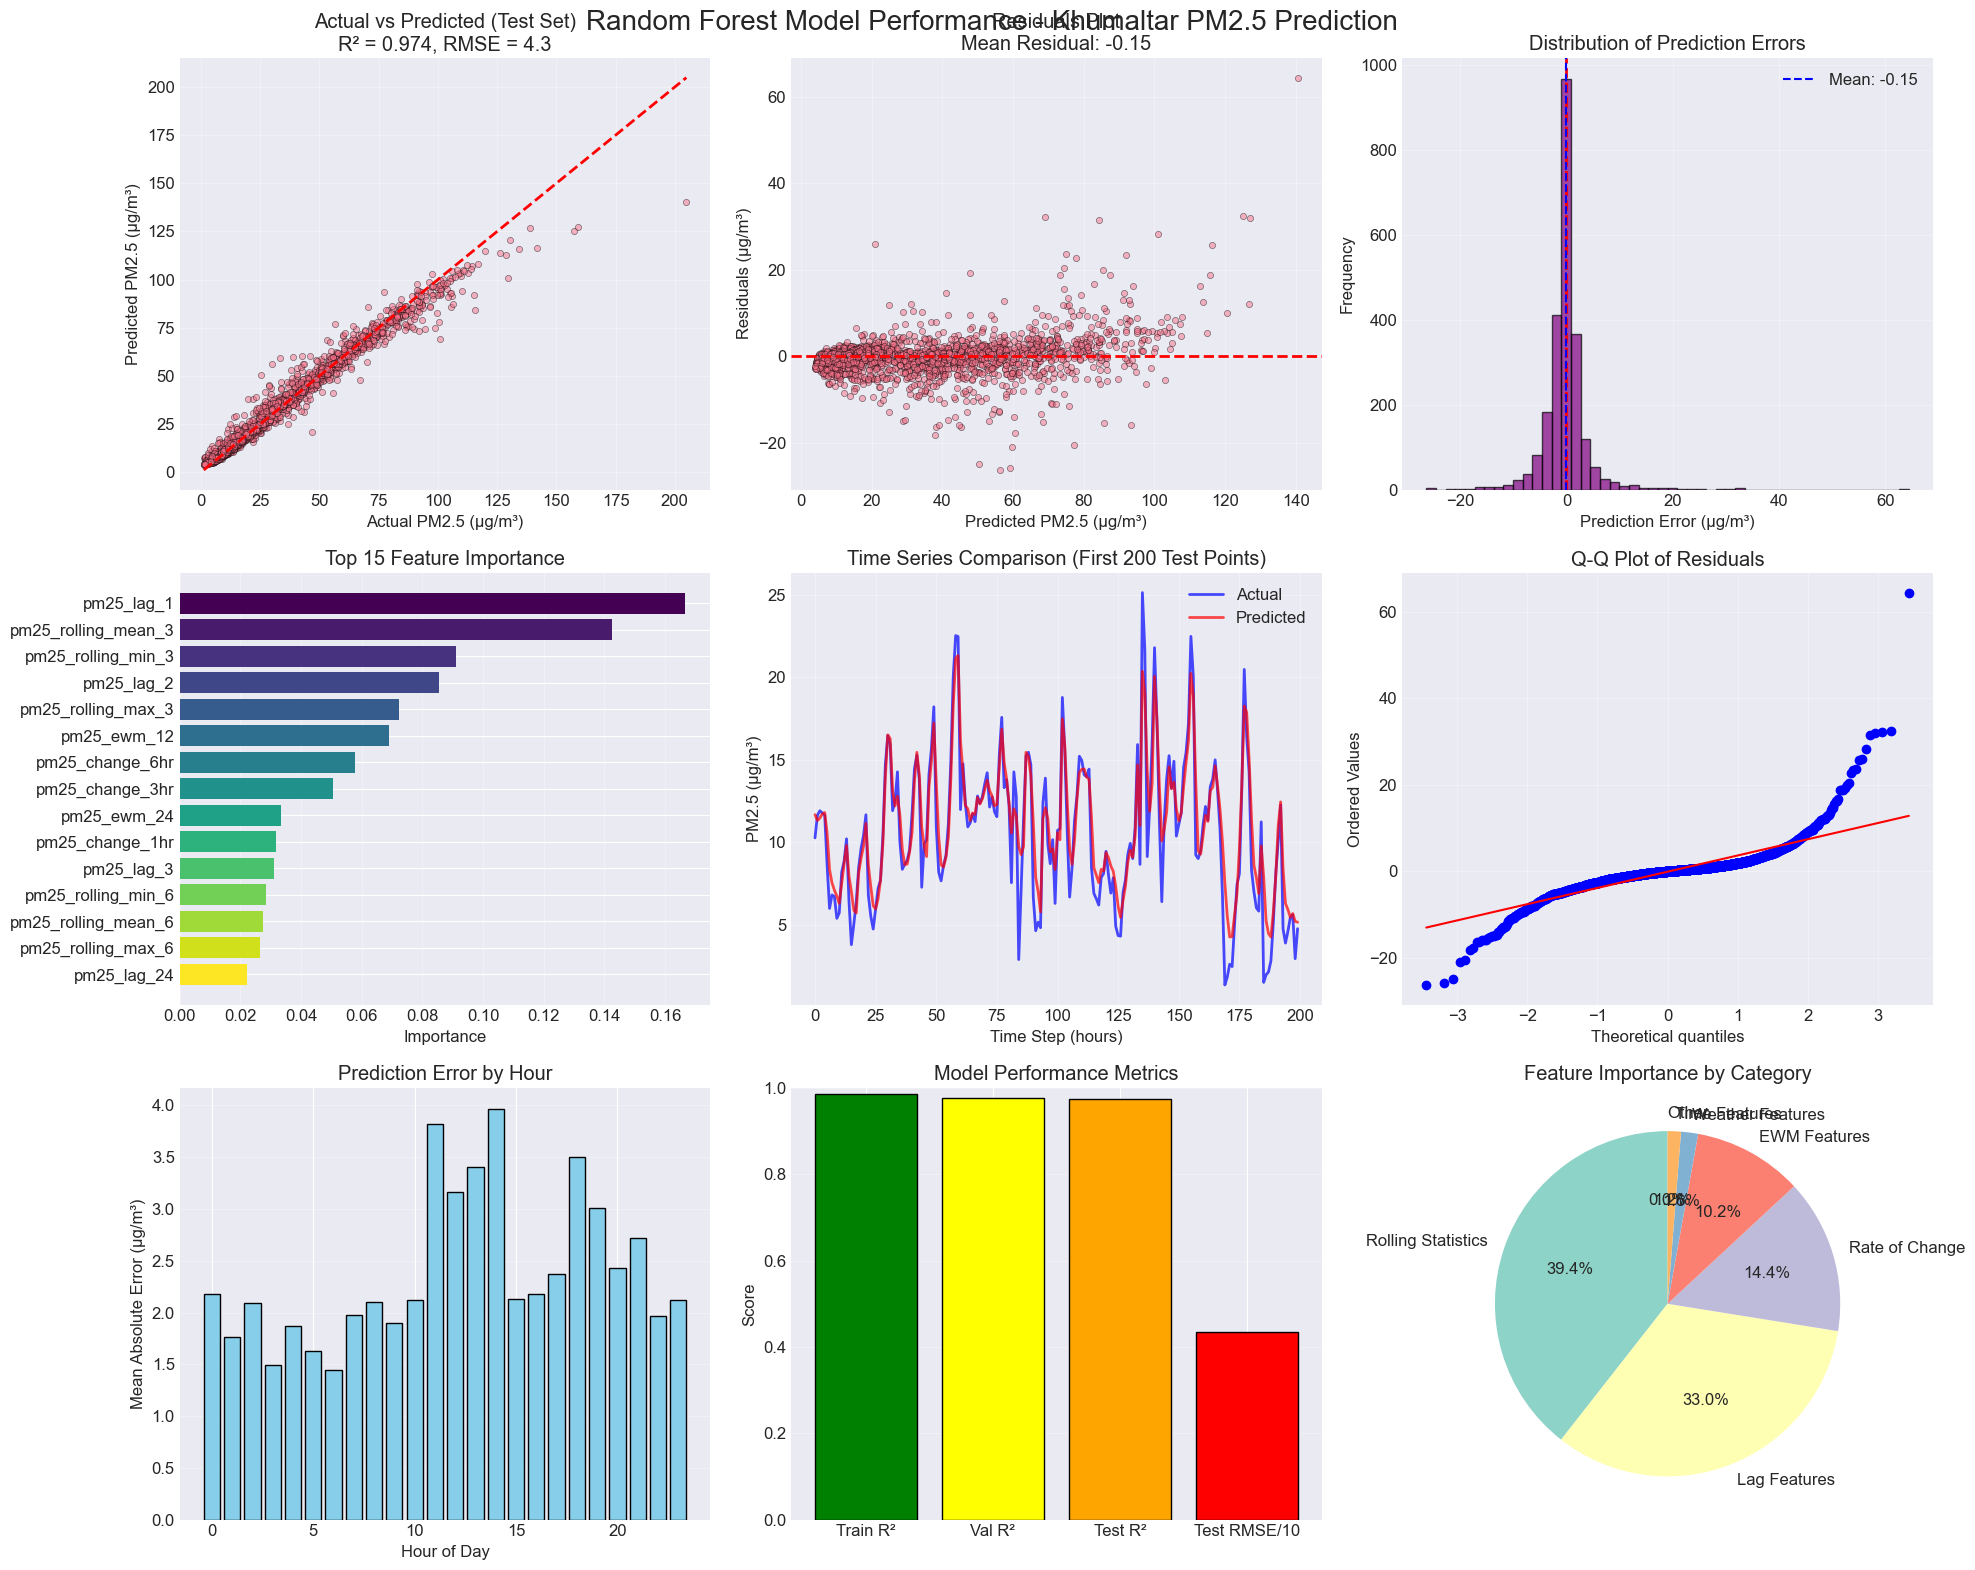

In [38]:
# ============================================================================
# STEP 10: VISUALIZATION OF RESULTS
# ============================================================================

print("\n" + "="*70)
print("STEP 10: VISUALIZATION OF RESULTS")
print("="*70)

fig = plt.figure(figsize=(20, 16))
fig.suptitle('Random Forest Model Performance - Khumaltar PM2.5 Prediction', fontsize=20, y=0.98)

# 1. Actual vs Predicted Scatter
ax1 = plt.subplot(3, 3, 1)
ax1.scatter(y_test, y_test_pred, alpha=0.5, edgecolors='k', linewidth=0.5, s=20)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual PM2.5 (µg/m³)')
ax1.set_ylabel('Predicted PM2.5 (µg/m³)')
ax1.set_title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.3f}, RMSE = {test_rmse:.1f}')
ax1.grid(True, alpha=0.3)

# 2. Residuals Plot
ax2 = plt.subplot(3, 3, 2)
residuals = y_test - y_test_pred
ax2.scatter(y_test_pred, residuals, alpha=0.5, edgecolors='k', linewidth=0.5, s=20)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted PM2.5 (µg/m³)')
ax2.set_ylabel('Residuals (µg/m³)')
ax2.set_title(f'Residuals Plot\nMean Residual: {residuals.mean():.2f}')
ax2.grid(True, alpha=0.3)

# 3. Residuals Distribution
ax3 = plt.subplot(3, 3, 3)
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='purple')
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.axvline(x=residuals.mean(), color='blue', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
ax3.set_xlabel('Prediction Error (µg/m³)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Prediction Errors')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature Importance (Top 15)
ax4 = plt.subplot(3, 3, 4)
top_features = feature_importance.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
ax4.barh(range(len(top_features)), top_features['importance'].values, color=colors)
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['feature'].values)
ax4.set_xlabel('Importance')
ax4.set_title('Top 15 Feature Importance')
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3, axis='x')

# 5. Time Series Comparison
ax5 = plt.subplot(3, 3, 5)
test_indices = range(min(200, len(y_test)))
ax5.plot(test_indices, y_test.iloc[:200].values, 'b-', label='Actual', linewidth=2, alpha=0.7)
ax5.plot(test_indices, y_test_pred[:200], 'r-', label='Predicted', linewidth=2, alpha=0.7)
ax5.set_xlabel('Time Step (hours)')
ax5.set_ylabel('PM2.5 (µg/m³)')
ax5.set_title('Time Series Comparison (First 200 Test Points)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Q-Q Plot
ax6 = plt.subplot(3, 3, 6)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot of Residuals')
ax6.grid(True, alpha=0.3)

# 7. Prediction Error by Hour
ax7 = plt.subplot(3, 3, 7)
test_df = pd.DataFrame({
    'hour': df.iloc[val_end:]['hour'].values,
    'error': np.abs(residuals)
})
hourly_error = test_df.groupby('hour')['error'].mean()
ax7.bar(hourly_error.index, hourly_error.values, color='skyblue', edgecolor='black')
ax7.set_xlabel('Hour of Day')
ax7.set_ylabel('Mean Absolute Error (µg/m³)')
ax7.set_title('Prediction Error by Hour')
ax7.grid(True, alpha=0.3, axis='y')

# 8. Model Performance Comparison
ax8 = plt.subplot(3, 3, 8)
metrics = ['Train R²', 'Val R²', 'Test R²', 'Test RMSE/10']
values = [train_r2, val_r2, test_r2, test_rmse/10]
colors = ['green', 'yellow', 'orange', 'red'] if test_r2 > 0.6 else ['red', 'orange', 'yellow', 'green']
ax8.bar(metrics, values, color=colors, edgecolor='black')
ax8.set_ylim([0, 1])
ax8.set_ylabel('Score')
ax8.set_title('Model Performance Metrics')
ax8.grid(True, alpha=0.3, axis='y')

# 9. Feature Importance by Category
ax9 = plt.subplot(3, 3, 9)
ax9.pie(category_importance.values, labels=category_importance.index, autopct='%1.1f%%',
        startangle=90, colors=plt.cm.Set3(range(len(category_importance))))
ax9.set_title('Feature Importance by Category')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


In [39]:
# ============================================================================
# STEP 11: MODEL SAVING AND SUMMARY
# ============================================================================

print("\n" + "="*70)
print("STEP 11: MODEL SAVING AND SUMMARY")
print("="*70)

# Save the model and scaler
joblib.dump(best_model, 'improved_random_forest_pm25_model.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

print("\n✅ Model saved as 'improved_random_forest_pm25_model.pkl'")
print("✅ Features list saved as 'selected_features.pkl'")

# Final Summary
print("\n" + "="*70)
print("FINAL MODEL SUMMARY")
print("="*70)

print(f"""
📊 DATASET SUMMARY:
   • Total samples: {len(df):,}
   • Date range: {df['datetime'].min()} to {df['datetime'].max()}
   • Features used: {len(selected_features)}
   • Training samples: {len(X_train):,}
   • Validation samples: {len(X_val):,}
   • Test samples: {len(X_test):,}

🏆 MODEL PERFORMANCE:
   • Training R²:     {train_r2:.4f}
   • Validation R²:   {val_r2:.4f}
   • Test R²:         {test_r2:.4f}
   • Test RMSE:       {test_rmse:.2f} µg/m³
   • Test MAE:        {test_mae:.2f} µg/m³
   • Test MAPE:       {test_mape:.2f}%

📈 FEATURE IMPORTANCE:
   • Most important: {feature_importance.iloc[0]['feature']} ({feature_importance.iloc[0]['importance']:.4f})
   • By category: {category_importance.index[0]} dominates with {category_importance.iloc[0]*100:.1f}%

{'✅ EXCELLENT MODEL!' if test_r2 > 0.7 else '⚠️ GOOD MODEL - Can be improved' if test_r2 > 0.6 else '🔄 MODEL NEEDS IMPROVEMENT'}
""")

print("="*70)
print("ANALYSIS COMPLETE")
print("="*70)


STEP 11: MODEL SAVING AND SUMMARY

✅ Model saved as 'improved_random_forest_pm25_model.pkl'
✅ Features list saved as 'selected_features.pkl'

FINAL MODEL SUMMARY

📊 DATASET SUMMARY:
   • Total samples: 15,799
   • Date range: 2022-04-04 17:00:00 to 2024-12-31 21:00:00
   • Features used: 38
   • Training samples: 11,059
   • Validation samples: 2,370
   • Test samples: 2,370

🏆 MODEL PERFORMANCE:
   • Training R²:     0.9850
   • Validation R²:   0.9762
   • Test R²:         0.9743
   • Test RMSE:       4.33 µg/m³
   • Test MAE:        2.38 µg/m³
   • Test MAPE:       12.88%

📈 FEATURE IMPORTANCE:
   • Most important: pm25_lag_1 (0.1667)
   • By category: Rolling Statistics dominates with 39.4%

✅ EXCELLENT MODEL!

ANALYSIS COMPLETE


In [40]:
from sklearn.metrics import mean_squared_error
import numpy as np

# naive model
naive_pred = X_test['pm25_lag_1'].values
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))
model_rmse = np.sqrt(mean_squared_error(y_test,y_test_pred))

print("Naive RMSE:", naive_rmse)
print("Your Model RMSE:", model_rmse)


Naive RMSE: 9.879256525095306
Your Model RMSE: 4.334637939848438


In [41]:
naive_pred = X_test['pm25_lag_1']
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))

print(naive_pred)
print(naive_rmse)

22146    12.167797
22147    10.272414
22148    11.645000
22149    11.913333
22150    11.783051
           ...    
26296    32.025001
26297    42.433899
26298    50.580001
26299    82.903335
26300    91.128335
Name: pm25_lag_1, Length: 2370, dtype: float64
9.879256525095306



STEP 12: TRAINING HORIZON-BASED MODELS

⏳ Training model for horizon: +1 hour(s) ahead
   Training samples : 11,008
   Validation samples: 2,359
   Test samples     : 2,359

   📊 Results for +1h model:
      Train R²  : 0.9339
      Val R²    : 0.9062
      Test R²   : 0.8868
      Test RMSE : 9.11 µg/m³
      Test MAE  : 5.42 µg/m³
      Test MAPE : 25.43%
   💾 Saved: model_1h_ahead.pkl

⏳ Training model for horizon: +2 hour(s) ahead
   Training samples : 11,007
   Validation samples: 2,359
   Test samples     : 2,359

   📊 Results for +2h model:
      Train R²  : 0.8899
      Val R²    : 0.8313
      Test R²   : 0.8059
      Test RMSE : 11.93 µg/m³
      Test MAE  : 7.33 µg/m³
      Test MAPE : 35.76%
   💾 Saved: model_2h_ahead.pkl

⏳ Training model for horizon: +3 hour(s) ahead
   Training samples : 11,006
   Validation samples: 2,359
   Test samples     : 2,359

   📊 Results for +3h model:
      Train R²  : 0.8626
      Val R²    : 0.7850
      Test R²   : 0.7451
      Test RMSE :

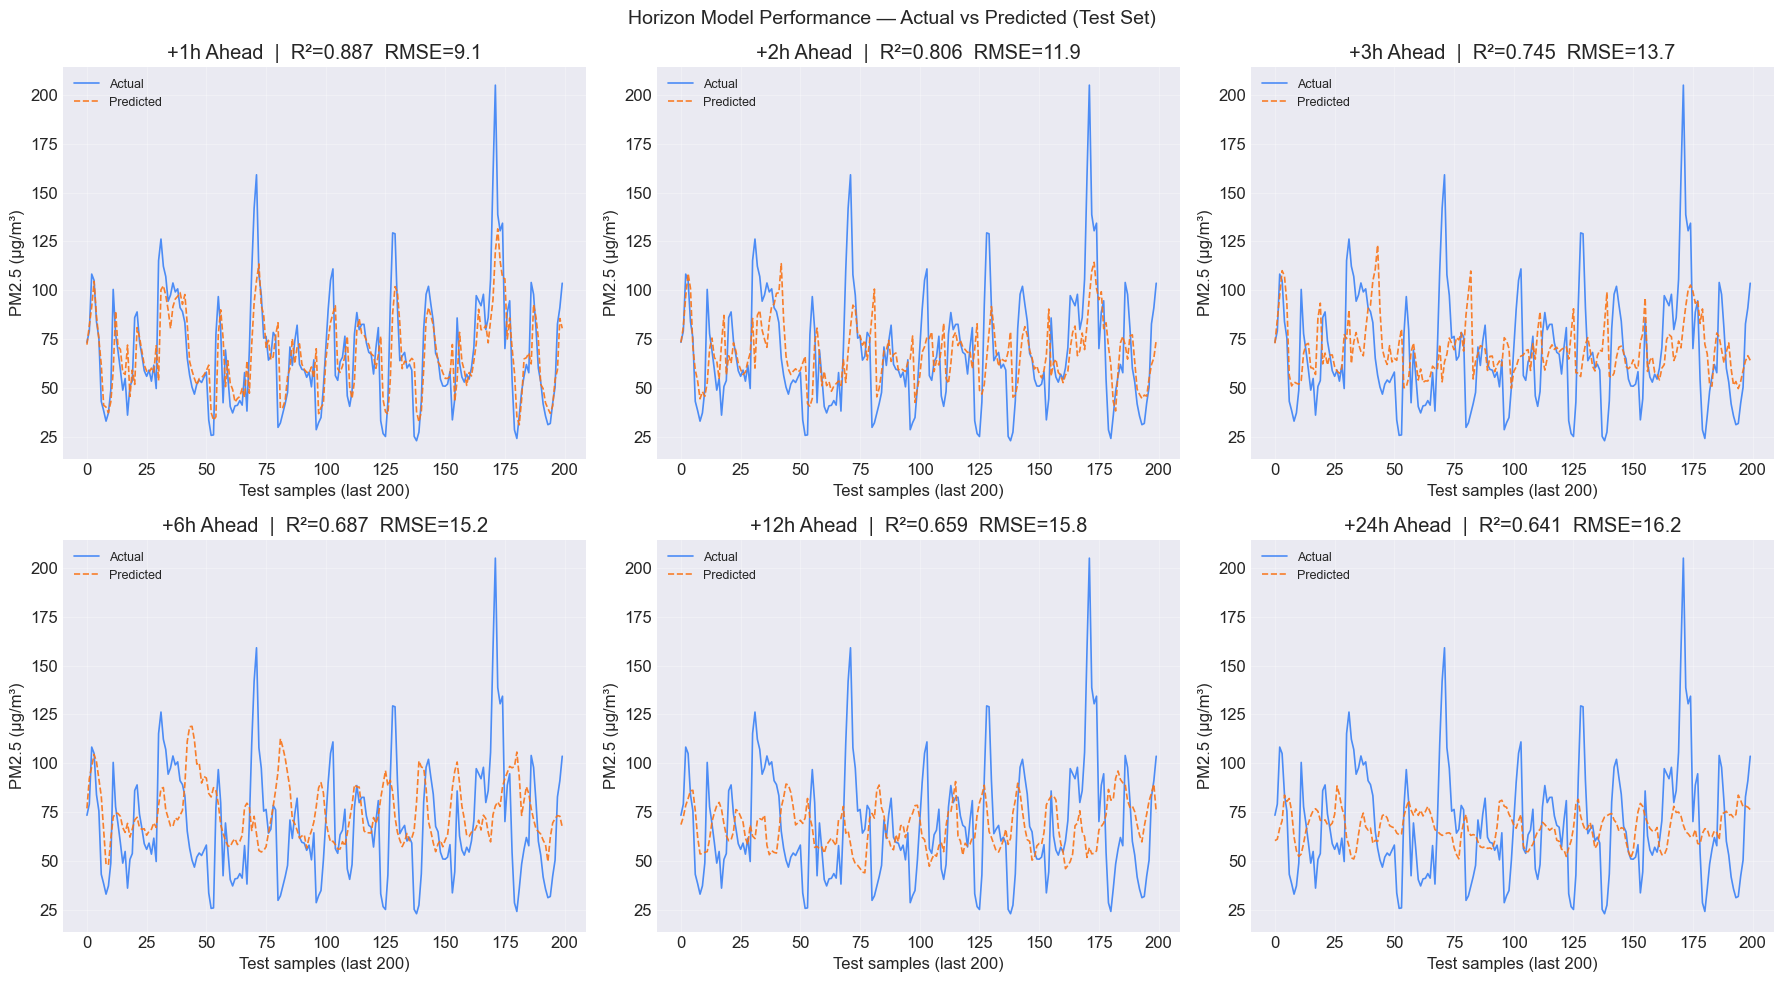


✅ Horizon model plots complete!


In [ ]:
# ============================================================================
# STEP 12: DIRECT MULTI-STEP HORIZON MODELS
# ============================================================================
# Each model is trained to predict PM2.5 at a specific future horizon
# using ONLY real historical features — no iterative rollout, no error compounding.
# ============================================================================

print("\n" + "="*70)
print("STEP 12: TRAINING HORIZON-BASED MODELS")
print("="*70)


# Horizons to train (hours ahead)
HORIZONS = [1, 2, 3, 6, 12, 24]

horizon_models   = {}   # stores trained models
horizon_metrics  = {}   # stores evaluation metrics

for h in HORIZONS:
    print(f"\n{'='*50}")
    print(f"⏳ Training model for horizon: +{h} hour(s) ahead")
    print(f"{'='*50}")

    # ── Target: PM2.5 value h hours in the future ──────────────────────
    # Input features are built from REAL past data only.
    # The model learns directly: "given current conditions, what will PM2.5 be in h hours?"
    y_future = df['pm25'].shift(-h)

    # Align: drop rows where future target is NaN (last h rows)
    valid_mask = y_future.notna()
    X_h = df.loc[valid_mask, selected_features].copy()
    y_h = y_future.loc[valid_mask].copy()

    # ── Same 70/15/15 chronological split as base model ────────────────
    n_h       = len(X_h)
    train_end = int(n_h * 0.70)
    val_end   = int(n_h * 0.85)

    X_train_h = X_h.iloc[:train_end]
    y_train_h = y_h.iloc[:train_end]
    X_val_h   = X_h.iloc[train_end:val_end]
    y_val_h   = y_h.iloc[train_end:val_end]
    X_test_h  = X_h.iloc[val_end:]
    y_test_h  = y_h.iloc[val_end:]

    print(f"   Training samples : {len(X_train_h):,}")
    print(f"   Validation samples: {len(X_val_h):,}")
    print(f"   Test samples     : {len(X_test_h):,}")

    # ── Use same best hyperparameters found in Step 7 ──────────────────
    # Longer horizons use slightly shallower trees to avoid overfitting
    max_depth_h = max(5, best_model.max_depth - (h // 6))

    model_h = RandomForestRegressor(
        n_estimators     = best_model.n_estimators,
        max_depth        = max_depth_h,
        min_samples_split= best_model.min_samples_split,
        min_samples_leaf = best_model.min_samples_leaf,
        max_features     = best_model.max_features,
        bootstrap        = True,
        max_samples      = best_model.max_samples,
        random_state     = 42,
        n_jobs           = -1
    )

    model_h.fit(X_train_h, y_train_h)

    # ── Evaluate ────────────────────────────────────────────────────────
    y_pred_train = model_h.predict(X_train_h)
    y_pred_val   = model_h.predict(X_val_h)
    y_pred_test  = model_h.predict(X_test_h)

    train_r2 = r2_score(y_train_h, y_pred_train)
    val_r2   = r2_score(y_val_h,   y_pred_val)
    test_r2  = r2_score(y_test_h,  y_pred_test)
    test_rmse= np.sqrt(mean_squared_error(y_test_h, y_pred_test))
    test_mae = mean_absolute_error(y_test_h, y_pred_test)
    test_mape= np.mean(np.abs((y_test_h.values - y_pred_test) / (y_test_h.values + 1e-9))) * 100

    horizon_metrics[h] = {
        'train_r2': train_r2,
        'val_r2'  : val_r2,
        'test_r2' : test_r2,
        'rmse'    : test_rmse,
        'mae'     : test_mae,
        'mape'    : test_mape,
    }

    print(f"\n   📊 Results for +{h}h model:")
    print(f"      Train R²  : {train_r2:.4f}")
    print(f"      Val R²    : {val_r2:.4f}")
    print(f"      Test R²   : {test_r2:.4f}")
    print(f"      Test RMSE : {test_rmse:.2f} µg/m³")
    print(f"      Test MAE  : {test_mae:.2f} µg/m³")
    print(f"      Test MAPE : {test_mape:.2f}%")

    # ── Save model ──────────────────────────────────────────────────────
    filename = f'model_{h}h_ahead.pkl'
    joblib.dump(model_h, filename)
    horizon_models[h] = model_h
    print(f"   💾 Saved: {filename}")

# ── Summary table ───────────────────────────────────────────────────────────
print("\n" + "="*70)
print("HORIZON MODEL SUMMARY")
print("="*70)
print(f"\n{'Horizon':>8} {'Train R²':>10} {'Val R²':>10} {'Test R²':>10} {'RMSE':>8} {'MAE':>7} {'MAPE':>8}")
print("-"*65)
for h, m in horizon_metrics.items():
    print(f"  +{h:2d}h   {m['train_r2']:>10.4f} {m['val_r2']:>10.4f} {m['test_r2']:>10.4f} "
          f"{m['rmse']:>7.2f}  {m['mae']:>6.2f}  {m['mape']:>6.2f}%")

print(f"\n✅ All {len(HORIZONS)} horizon models trained and saved!")
print("   Files: " + ", ".join([f"model_{h}h_ahead.pkl" for h in HORIZONS]))

# ── Visual comparison: base model vs horizon models ─────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Horizon Model Performance — Actual vs Predicted (Test Set)', fontsize=14)

for idx, h in enumerate(HORIZONS):
    ax = axes[idx // 3][idx % 3]
    model_h  = horizon_models[h]
    
    valid_mask = df['pm25'].shift(-h).notna()
    X_h_full  = df.loc[valid_mask, selected_features]
    y_h_full  = df['pm25'].shift(-h).loc[valid_mask]
    n_h       = len(X_h_full)
    X_test_plot = X_h_full.iloc[int(n_h * 0.85):]
    y_test_plot = y_h_full.iloc[int(n_h * 0.85):]
    y_pred_plot = model_h.predict(X_test_plot)

    # Plot last 200 points for clarity
    n_plot = min(200, len(y_test_plot))
    ax.plot(range(n_plot), y_test_plot.values[-n_plot:],
            color='#3b82f6', linewidth=1.2, label='Actual', alpha=0.9)
    ax.plot(range(n_plot), y_pred_plot[-n_plot:],
            color='#f97316', linewidth=1.2, linestyle='--', label='Predicted', alpha=0.9)

    m = horizon_metrics[h]
    ax.set_title(f'+{h}h Ahead  |  R²={m["test_r2"]:.3f}  RMSE={m["rmse"]:.1f}')
    ax.set_xlabel('Test samples (last 200)')
    ax.set_ylabel('PM2.5 (µg/m³)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("\n✅ Horizon model plots complete!")